In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize 

from src.model import *

In [2]:
a = 0.1
b = 0.2

def _P(f, a=a, b=b):
    if f > b:
        return 1
    return (f-a)/(b-a)

def _p(f, a=a, b=b):
    return 1/(b-a)

Ef = (a+b)/2
#parameters of utility
sigma = 1
S = 8

#parameters of firms


c = 0.4 # costs
ef = 0.004 # entrance costs
r = 0.1 #return of interest
alpha = 0.9

n = 100

data = {"a": [a]*n,
        "b": [b]*n,
        "sigma": [sigma]*n,
        "S": [S]*n,
        "c": [c]*n,
        "ef": [ef]*n,
        "r": [r]*n,
        "alpha": [alpha]*n}

df = pd.DataFrame(data)

Noke = ApsundNokeModelFC(distr = np.random.uniform,
                    data = df)

Noke.scenario(out=False)

result = Noke.getData()

result.describe()

,a,b,sigma,S,c,ef,r,alpha,NPV_ent,M,C_mean,C_max,C_min_ex,K,X,P
count,1.000000e+02,1.000000e+02,100.0,100.0,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,1.000000e-01,2.000000e-01,1.0,8.0,4.000000e-01,4.000000e-03,1.000000e-01,9.000000e-01,-0.001717,0.513700,0.129626,0.159959,0.166171,0.041200,0.099102,7.000000e-01
std,2.789540e-17,5.579081e-17,0.0,0.0,1.115816e-16,8.717313e-19,2.789540e-17,4.463264e-16,0.000000,0.012606,0.003108,0.005311,0.007184,0.051918,0.000832,1.867117e-16
min,1.000000e-01,2.000000e-01,1.0,8.0,4.000000e-01,4.000000e-03,1.000000e-01,9.000000e-01,-0.001717,0.460000,0.124337,0.152761,0.154830,0.020000,0.098039,7.000000e-01
25%,1.000000e-01,2.000000e-01,1.0,8.0,4.000000e-01,4.000000e-03,1.000000e-01,9.000000e-01,-0.001717,0.510000,0.127201,0.156324,0.161117,0.030000,0.098684,7.000000e-01
50%,1.000000e-01,2.000000e-01,1.0,8.0,4.000000e-01,4.000000e-03,1.000000e-01,9.000000e-01,-0.001717,0.510000,0.128984,0.158486,0.165833,0.040000,0.099338,7.000000e-01
75%,1.000000e-01,2.000000e-01,1.0,8.0,4.000000e-01,4.000000e-03,1.000000e-01,9.000000e-01,-0.001717,0.520000,0.131898,0.161765,0.169817,0.040000,0.099338,7.000000e-01
max,1.000000e-01,2.000000e-01,1.0,8.0,4.000000e-01,4.000000e-03,1.000000e-01,9.000000e-01,-0.001717,0.530000,0.141520,0.180857,0.189165,0.540000,0.102740,7.000000e-01


# Baseline

In [3]:
def check_bias(r=r, S=S, c=c, sigma=sigma, Ef=Ef, ef=ef, alpha=alpha):
    """
        K = x[0], M = x[1], F = x[2]
    """
    def f(x):
        K, M, F = x[0], x[1], x[2]
        return [
            (1+r)/r *( S/8 * ((1-c)/(1+sigma*(M+K)))**2 - Ef) - ef,
            (1+r)/r * S/8 *((1-c)/(1+sigma*M))**2 - (1/r - alpha/(1+r-alpha)) * Ef - (1+r)/(1+r-alpha) * F,
            (1-alpha)*(1-_P(F)) * M - K * _P(F)
        ]
    return f
        

In [12]:
Cmax = result["C_max"].mean()
Cminex = result["C_min_ex"].mean()
K = result["K"].mean()
M = result["M"].mean()
F = Cmax * 3/3 + Cminex * 0/3
print(f"K={K}, M={M}, F={F}")

print(check_bias()([K, M, F]))

K=0.0441, M=0.5108, F=0.1612958830194215
[np.float64(-0.016089153795324575), np.float64(0.022799754373629022), np.float64(-0.007261421457885369)]


In [4]:
ans = scipy.optimize.fsolve(check_bias(),[0.05,1,0.15], maxfev=1000)
ans, check_bias()(ans)

(array([0.03045453, 0.51686441, 0.16292407]),
 [np.float64(-1.1464353771861724e-11),
  np.float64(-4.666267372499533e-13),
  np.float64(1.565320789653768e-12)])

In [14]:
K, M, F = ans
P = _P(F)/(1-alpha+alpha*_P(F))
A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*F)) ** 0.5
B = (S/8 * (1+r)/(r*ef + (1+r)*Ef))**0.5

print(f"A={A} B={B}")

print(
    "M + K =\t",
    M + K,
    M/P,
    1/sigma * ((1-c)*B - 1)
)
print(
    "M =\t",
    1/sigma * ((1-c) * A - 1),
    1/sigma * ((1-c)*B - 1)*P
)
#(1-c)(A-B*P) = 1 - P
c_r = 1 - (1-P)/(A-P*B)
print("C = \t", c_r)

A=2.528107350189967 B=2.5788648928218905
M + K =	 0.5473189356984967 0.5473189357009843 0.5473189356931343
M =	 0.5168644101139803 0.5168644101067725
C = 	 0.40000000007772096


In [15]:
ef_r = (1+r)/r * (S/8 * ((P*(1-c))/(P+(1-c)*A-1))**2-Ef)
ef_r

np.float64(0.003999999983682723)

In [16]:
ans = scipy.optimize.fsolve(check_bias(),[0.05,1,0.15], maxfev=1000)
print("initial: ", ans, ans[0]/ans[1])
print("x=", 1/4 * (1-c)/(1+sigma*ans[1]))
ans = scipy.optimize.fsolve(check_bias(c = 0.05),[0.05,1,0.15], maxfev=1000)
print("after tax: ", ans, ans[0]/ans[1])
print("x=", 1/4 * (1-c-0.05)/(1+sigma*ans[1]))

ans = scipy.optimize.fsolve(check_bias(ef=0.1),[0.05,1,0.15], maxfev=1000)
print("initial: ", ans, ans[0]/ans[1])
ans = scipy.optimize.fsolve(check_bias(ef=0.2),[0.05,1,0.15], maxfev=1000)
print("after licence: ", ans, ans[0]/ans[1])

initial:  [0.03045453 0.51686441 0.16292407] 0.05892169201122374
x= 0.09888820582764439
after tax:  [0.06616273 1.38375892 0.1676527 ] 0.04781377039494173
x= 0.057682007615512974
initial:  [0.01615871 0.4881209  0.17512927] 0.03310391814908029
after licence:  [0.00566314 0.45739549 0.1889828 ] 0.012381275237568008


## Графики

In [133]:
ans = scipy.optimize.fsolve(check_bias(),[0.05,1,0.15], maxfev=1000)
K, M, F = ans
X = 1/4 * (1-c)/(1+sigma * M)
K_M = K/M
P = (1+c)/2
Q = X*M

Noke = ApsundNokeModelFC(distr = np.random.uniform,
                    data = df)

Noke.scenario(out=False)

result = Noke.getData()

print(F, M, K_M, X, P, Q)

0.1629240720580228 0.5168644101141857 0.05892169201122374 0.09888820582764439 0.7 0.0511117941723556


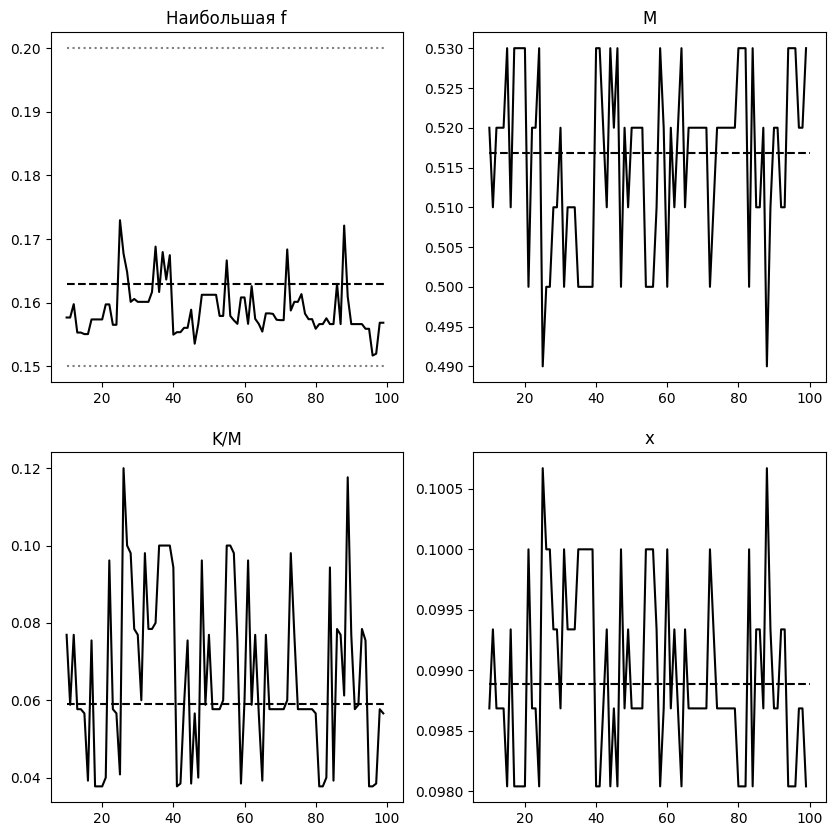

In [87]:
def otrezok(val, l=10, r=100, color='black', linestyle="--"):
    point1 = [l, val]
    point2 = [r, val]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, color=color, linestyle=linestyle)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('Наибольшая f')
plt.plot(result["C_max"][10:], color='black')

otrezok(F)
otrezok(Ef, color="gray", linestyle=":")
otrezok(b, color="gray", linestyle=":")

#plt.plot([10, F], [99, F], 'bo', linestyle="--")

plt.subplot(2,2,2)
plt.title('M')
plt.plot(result["M"][10:], color='black')
otrezok(M)

plt.subplot(2,2,3)
plt.title('K/M')
plt.plot(result["K"][10:]/result["M"][10:], color='black')
otrezok(K/M)

plt.subplot(2,2,4)
plt.title('x')
plt.plot(result["X"][10:], color='black')
otrezok(X)

# Потоварные налоги

In [45]:
def check_tax_bias(r=r, S=S, c=c, sigma=sigma, Ef=Ef, ef=ef, alpha=alpha):
    """
        K = x[0], M = x[1], F = x[2], t=x[3]
    """    
    def tax_condition(f, T):
        P = _P(f) / (1 - alpha + alpha * _P(f))
        A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*f)) ** 0.5
        B = (S/8 * (1+r)/(r*ef + (1+r)*Ef))**0.5
        Pd = (1-alpha)*_p(f) / (1 - alpha + alpha * _P(f)) ** 2
        Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*f) ** 1.5
        dc_df = - (Pd * (B - A) + Ad * (P-1)) / (A-P*B)**2 #производная вся
        # 1-c-2*tax - 1/A + tax* Ad/A**2 /dc_df
        return 1 - c - 2*T - 1/A + T * 1 /dc_df * Ad / A**2

    def f(x):
        K, M, F, T = x[0], x[1], x[2], x[3]
        return [
            (1+r)/r *( S/8 * ((1-c-T)/(1+sigma*(M+K)))**2 - Ef) - ef,
            (1+r)/r * S/8 *((1-c-T)/(1+sigma*M))**2 - (1/r - alpha/(1+r-alpha)) * Ef - (1+r)/(1+r-alpha) * F,
            (1-alpha)*(1-_P(F)) * M - K * _P(F),
            tax_condition(F, T)
        ]
    return f

In [141]:
ans = scipy.optimize.fsolve(check_tax_bias(),[0.017,0.25,0.15,0.1], maxfev=1000)
print(ans)
tax_income = ans[3] * ans[1] / 4 * (1-c-ans[3])/(1+sigma*ans[1])
print(tax_income)

K, M, F, T = ans
X = 1/4 * (1-c-T)/(1+sigma * M)
P = (1+c+T)/2
Q = X*M

print(F, M, K/M, X, P, Q, T, T*Q)

[0.01777882 0.25884146 0.1592817  0.10496814]
0.0026711204420672833
0.15928169561497685 0.2588414649831273 0.06868613313184022 0.09831100135796718 0.7524840700531567 0.025446963615454444 0.10496814010631346 0.002671120442067283


In [139]:
Points_t = []
Points_tr = []

for tax in np.arange(0.00, 0.2, 0.01):
    ans = scipy.optimize.fsolve(check_bias(c = c + tax),[K, M, F], maxfev=10000)
    K, M, F = ans
    #if M < 0 or K < 0: break
    P = _P(F)/(1-alpha+alpha*_P(F))
    A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*F)) ** 0.5
    B = (S/8 * (1+r)/(r*ef + (1+r)*Ef))**0.5
    Pd = (1-alpha)*_p(F) / (1 - alpha + alpha * _P(F)) ** 2
    Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*F) ** 1.5
    dc_df = - (Pd * (B - A) + Ad * (P-1)) / (A-P*B)**2 #производная вся
    R = M * (1-c-tax) / ((4 * (1+ sigma*M)))
    check = check_tax_bias()([K, M, F, tax])[3]
    Points_t.append(tax)
    Points_tr.append(tax * R)

    print(K, M, F, tax, tax * R,  1-c-2*tax - 1/A + tax* Ad/A**2 /dc_df, check)
    

0.030454525581767613 0.5168644101078065 0.16292407206059403 0.0 0.0 0.19637745243892235 0.20444717668774381
0.029326338537507324 0.4922039482090546 0.16266383427599185 0.01 0.00048652922040563073 0.17681652380587223 0.184780524178232
0.028185672439124627 0.46755596537675104 0.16238965149096665 0.02 0.0009239254458309452 0.15729611480128883 0.1651412753698828
0.027031384512122947 0.44292160437271 0.16210033512546052 0.03 0.0013122610770780604 0.13782148193098073 0.1455326187510206
0.025862184004211596 0.41830215594916575 0.16179455277409333 0.04 0.0016516170856044913 0.11839873749275222 0.12595823701263517
0.02467660673674681 0.39369908428468914 0.16147080497045846 0.05 0.0019420843674059177 0.09903502361314281 0.10642240531410446
0.02347298407618418 0.3691140580127444 0.16112739712188534 0.06 0.0021837653717783965 0.07973872993097667 0.08693011397845349
0.02224940479959369 0.34454898835615705 0.16076240536444683 0.07 0.002376776074860912 0.060519768245142914 0.06748722306141426
0.02100

## Графики

In [138]:
ans = scipy.optimize.fsolve(check_bias(),[0.05,1,0.15], maxfev=1000)
K0, M0, F0 = ans
X0 = 1/4 * (1-c)/(1+sigma * M0)

t = 0.1

ans = scipy.optimize.fsolve(check_bias(c=c+t),[0.05,1,0.15], maxfev=1000)
K1, M1, F1 = ans
X1 = 1/4 * (1-c-t)/(1+sigma * M1)
P1 = (1+c+t)/2
Q1 = X1*M1

for i in range(50, 100):
    df.loc[i,  "c"] = (c+t)

Noke = ApsundNokeModelFC(distr = np.random.uniform,
                    data = df)

Noke.scenario(out=False)

result = Noke.getData()

for i in range(50, 100):
    df.loc[i,  "c"] = c

print(F1, M1, K1/M1, X1, P1, Q1)


0.1595142968927247 0.2709973495623597 0.06802685270727732 0.09834796275778313 0.75 0.02665203724221689


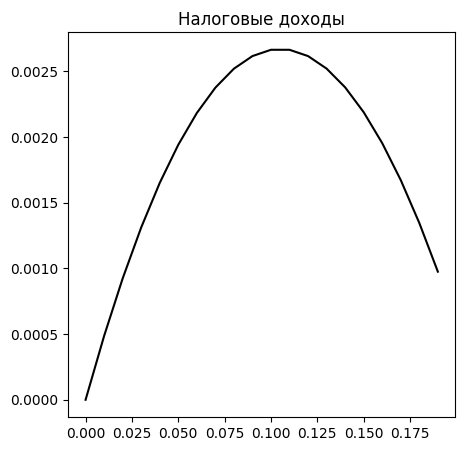

In [140]:
plt.figure(figsize=(5,5))
plt.title('Налоговые доходы')
plt.plot(Points_t, Points_tr, color='black')

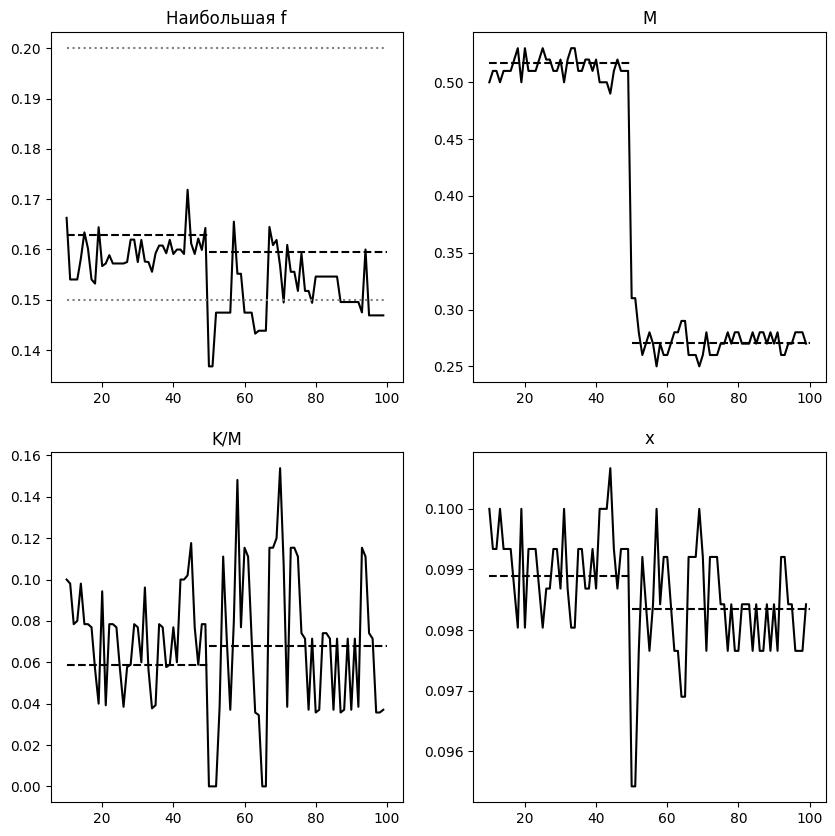

In [102]:
l = 10
r = 100
divider = 50

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('Наибольшая f')
plt.plot(result["C_max"][10:], color='black')

otrezok(F0, l, divider)
otrezok(F1, divider, r)
otrezok(Ef, color="gray", linestyle=":")
otrezok(b, color="gray", linestyle=":")

#plt.plot([10, F], [99, F], 'bo', linestyle="--")

plt.subplot(2,2,2)
plt.title('M')
plt.plot(result["M"][10:], color='black')
otrezok(M0, l, divider)
otrezok(M1, divider, r)

plt.subplot(2,2,3)
plt.title('K/M')
plt.plot(result["K"][10:]/result["M"][10:], color='black')
otrezok(K0/M0, l, divider)
otrezok(K1/M1, divider, r)

plt.subplot(2,2,4)
plt.title('x')
plt.plot(result["X"][10:], color='black')
otrezok(X0, l, divider)
otrezok(X1, divider, r)

# Лицензии 

In [49]:
def check_lic_bias(r=r, S=S, c=c, sigma=sigma, Ef=Ef, ef=ef, alpha=alpha):
    """
        K = x[0], M = x[1], F = x[2], t=x[3]
    """    
    def lic_condition(F, L):
        P = _P(F)/(1-alpha+alpha*_P(F))
        A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*F)) ** 0.5
        Pd = (1-alpha)*_p(F) / (1 - alpha + alpha * _P(F)) ** 2
        Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*F) ** 1.5
        de_df = (S*(1+r)*(1-c)**2 * P * (Pd*((1-c)*A-1)-(1-c)*P*Ad))/(4*r*(P+(1-c)*A-1)**3)
        df_de = 1/de_df
        check = ((1-c)*A-1)*(1/P-1) + L * (1-c)*Ad * df_de * (1/P-1) + L*((1-c)*A-1)*(-Pd/P**2 * df_de)
        return check

    def f(x):
        K, M, F, L = x[0], x[1], x[2], x[3]
        return [
            (1+r)/r *( S/8 * ((1-c)/(1+sigma*(M+K)))**2 - Ef) - ef - L,
            (1+r)/r * S/8 *((1-c)/(1+sigma*M))**2 - (1/r - alpha/(1+r-alpha)) * Ef - (1+r)/(1+r-alpha) * F,
            (1-alpha)*(1-_P(F)) * M - K * _P(F),
            lic_condition(F, L)
        ]
    return f


In [121]:
Points_l = []
Points_lK = []

for l in np.arange(0.0, 0.4, 0.01):
    ans = scipy.optimize.fsolve(check_bias(ef = ef + l),[K, M, F], maxfev=10000)
    K, M, F = ans
    #if M < 0 or K < 0: break
    P = _P(F)/(1-alpha+alpha*_P(F))
    A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*F)) ** 0.5
    Pd = (1-alpha)*_p(F) / (1 - alpha + alpha * _P(F)) ** 2
    Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*F) ** 1.5
    de_df = (S*(1+r)*(1-c)**2 * P * (Pd*((1-c)*A-1)-(1-c)*P*Ad))/(4*r*(P+(1-c)*A-1)**3)
    df_de = 1/de_df
    check = ((1-c)*A-1)*(1/P-1) + l * (1-c)*Ad * df_de * (1/P-1) + l*((1-c)*A-1)*(-Pd/P**2 * df_de)
    check1 = P*((1-c)*A-1)*(1-P) + l * df_de* (P*(1-c)*Ad * (1-P) - ((1-c)*A-1)*(Pd))
    check1 = (P*((1-c)*A-1)*(1-P)) / (P*(1-c)*Ad * (1-P) - ((1-c)*A-1)*(Pd))  + l * df_de
    check1 = check_lic_bias()([K, M, F, l])[3]
    Points_l.append(l)
    Points_lK.append(l*K)

    print(l, K,  1/sigma * ((1-c)*A-1)*(1/P-1), l * K, check, check1 )


0.0 0.030454525583931732 0.02866760501985215 0.0 0.02866760501985215 0.030454525583931743
0.01 0.028734350721175635 0.026894992764003194 0.00028734350721175634 0.015591399508814479 0.027043261229884798
0.02 0.027071816392641175 0.025193488957199302 0.0005414363278528235 0.003596671873176624 0.023803331064533428
0.03 0.025465341679485158 0.023560892347564734 0.0007639602503845547 -0.007378200371395385 0.020728441015501697
0.04 0.023913365943300468 0.02199503634439217 0.0009565346377320188 -0.017392216561967783 0.017812401695735655
0.05 0.022414350439538315 0.02049379120746414 0.0011207175219769157 -0.026501787777253157 0.015049137813580027
0.06 0.02096677980712186 0.019055066016878883 0.0012580067884273116 -0.03476077948122813 0.012432696637075025
0.07 0.01956916342210089 0.01767681042549421 0.0013698414395470625 -0.042220561092506805 0.009957255500276416
0.08 0.018220036614344952 0.01635701619554216 0.0014576029291475962 -0.04893006165029269 0.0076171283502552475
0.09 0.016917961747703

In [144]:
ans = scipy.optimize.fsolve(check_lic_bias(),[0.03446, 1.4467, 0.15, 0.12], maxfev=1000)
print(ans)
license_income = ans[0] * ans[3]
print(license_income)

K, M, F, L = ans
X = 1/4 * (1-c)/(1+sigma * M)
P = (1+c)/2
Q = X*M

print(F, M, K/M, X, P, Q, L, L*K)

[0.01359773 0.48163213 0.17798329 0.11724755]
0.0015943001206820818
0.1779832907927441 0.48163213462943905 0.028232598270244397 0.10123970484584251 0.7524840700531567 0.04876029515415749 0.11724754960717963 0.0015943001206820818


## Графики

In [116]:
ans = scipy.optimize.fsolve(check_bias(),[0.05,1,0.15], maxfev=1000)
K0, M0, F0 = ans
X0 = 1/4 * (1-c)/(1+sigma * M0)

l = 0.046

ans = scipy.optimize.fsolve(check_bias(ef=ef+l),[0.05,1,0.15], maxfev=1000)
K1, M1, F1 = ans
X1 = 1/4 * (1-c)/(1+sigma * M1)
P1 = (1+c)/2
Q1 = X1*M1

for i in range(50, 100):
    df.loc[i,  "ef"] = (ef+l)

Noke = ApsundNokeModelFC(distr = np.random.uniform,
                    data = df)

Noke.scenario(out=False)

result = Noke.getData()

for i in range(50, 100):
    df.loc[i,  "ef"] = ef

print(F1, M1, K1/M1, X1, P1, Q1)


0.1686248816534499 0.5032333582635979 0.045719741281277745 0.09978490643213686 0.7 0.05021509356786313


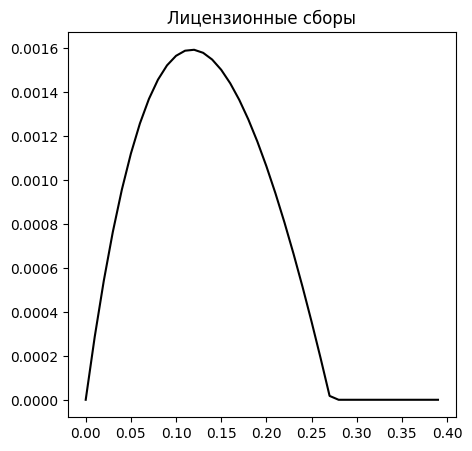

In [124]:
plt.figure(figsize=(5,5))
plt.title('Лицензионные сборы')
plt.plot(Points_l, Points_lK, color='black')

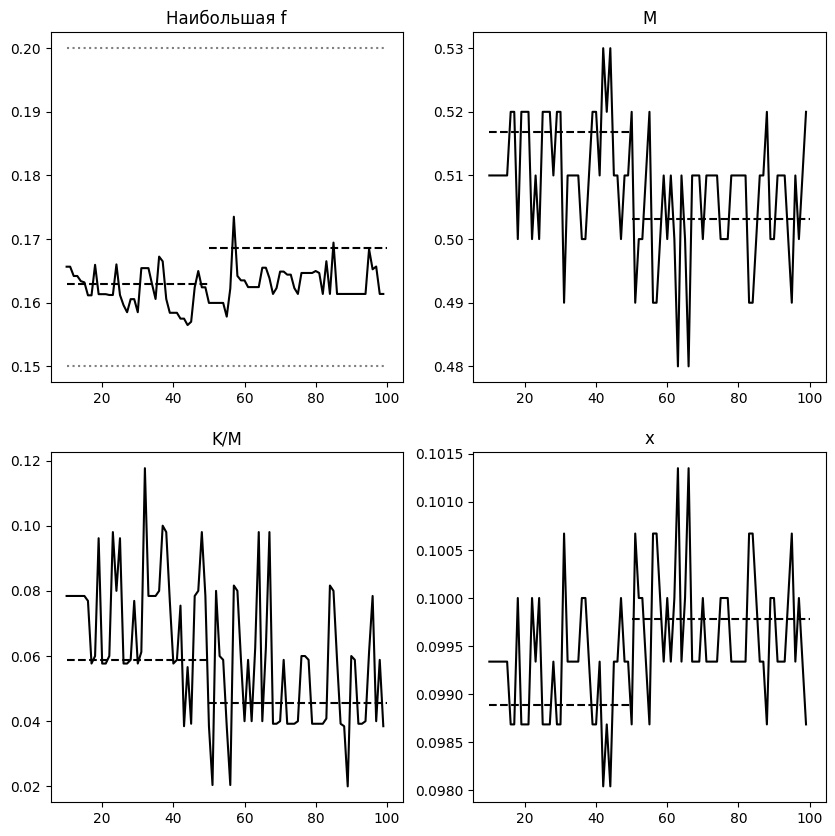

In [108]:
l = 10
r = 100
divider = 50

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('Наибольшая f')
plt.plot(result["C_max"][10:], color='black')

otrezok(F0, l, divider)
otrezok(F1, divider, r)
otrezok(Ef, color="gray", linestyle=":")
otrezok(b, color="gray", linestyle=":")

#plt.plot([10, F], [99, F], 'bo', linestyle="--")

plt.subplot(2,2,2)
plt.title('M')
plt.plot(result["M"][10:], color='black')
otrezok(M0, l, divider)
otrezok(M1, divider, r)

plt.subplot(2,2,3)
plt.title('K/M')
plt.plot(result["K"][10:]/result["M"][10:], color='black')
otrezok(K0/M0, l, divider)
otrezok(K1/M1, divider, r)

plt.subplot(2,2,4)
plt.title('x')
plt.plot(result["X"][10:], color='black')
otrezok(X0, l, divider)
otrezok(X1, divider, r)

# Нэшевское равновесие

In [52]:
def check_nash_bias(r=r, S=S, c=c, sigma=sigma, Ef=Ef, ef=ef, alpha=alpha):
    """
        K = x[0], M = x[1], F = x[2], t=x[3]
    """
    def A(f):
        return (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*f)) ** 0.5
    
    def t_conditiion(f, L, T):
        P = _P(f) / (1 - alpha + alpha * _P(f))
        A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*f)) ** 0.5
        B = (S/8 * (1+r)/(r*(ef+L) + (1+r)*Ef))**0.5
        Pd = (1-alpha)*_p(f) / (1 - alpha + alpha * _P(f)) ** 2
        Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*f) ** 1.5
        dc_df = - (Pd * (B - A) + Ad * (P-1)) / (A-P*B)**2 
        return 1-c-2*T-1/A - T * (1/dc_df * Ad / A**2)
    
    def lic_condition(F, L, T):
        P = _P(F)/(1-alpha+alpha*_P(F))
        A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*F)) ** 0.5
        Pd = (1-alpha)*_p(F) / (1 - alpha + alpha * _P(F)) ** 2
        Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*F) ** 1.5
        de_df = (S*(1+r)*(1-c-T)**2 * P * (Pd*((1-c-T)*A-1)-(1-c)*P*Ad))/(4*r*(P+(1-c-T)*A-1)**3)
        df_de = 1/de_df
        check = ((1-c-T)*A-1)*(1/P-1) + L * (1-c-T)*Ad * df_de * (1/P-1) + L*((1-c-T)*A-1)*(-Pd/P**2 * df_de)
        return check

    def f(x):
        K, M, F, L, T = x[0], x[1], x[2], x[3], x[4]
        return [
            (1+r)/r *( S/8 * ((1-c-T)/(1+sigma*(M+K)))**2 - Ef) - ef - L,
            (1+r)/r * S/8 *((1-c-T)/(1+sigma*M))**2 - (1/r - alpha/(1+r-alpha)) * Ef - (1+r)/(1+r-alpha) * F,
            (1-alpha)*(1-_P(F)) * M - K * _P(F),
            t_conditiion(F, L, T),
            lic_condition(F, L, T)
        ]
    return f

In [150]:
ans = scipy.optimize.fsolve(check_nash_bias(),[0.03446, 1.4467, 0.15, 0.12, 0.05], maxfev=1000)
print(ans)
tax_income = ans[4] * ans[1] / 4 * (1-c-ans[4])/(1+sigma*ans[1])
print("tax income=",tax_income)
license_income = ans[3]*ans[0]
print("licence income=",license_income)
print("sum=", license_income+tax_income)

K, M, F, L, T = ans
X = 1/4 * (1-c-T)/(1+sigma * M)
P = (1+c+T)/2
Q = X*M

print(F, M, K/M, X, P, Q, T, L, L*K+T*Q)

[0.00737236 0.24403689 0.17679901 0.12227917 0.09712664]
tax income= 0.0023952962261925455
licence income= 0.0009014856498793407
sum= 0.0032967818760718864
0.1767990114484107 0.2440368947491016 0.030210009385268993 0.10105676181265719 0.7485633196823647 0.02466157834616045 0.0971266393647294 0.12227916587117568 0.0032967818760718864


# Паретовский оптимум

In [54]:
def check_pareto_bias(r=r, S=S, c=c, sigma=sigma, Ef=Ef, ef=ef, alpha=alpha):
    """
        K = x[0], M = x[1], F = x[2], t=x[3]
    """
    def A(f):
        return (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*f)) ** 0.5
    
    def t_conditiion(f, L, T):
        P = _P(f) / (1 - alpha + alpha * _P(f))
        A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*f)) ** 0.5
        B = (S/8 * (1+r)/(r*(ef+L) + (1+r)*Ef))**0.5
        Pd = (1-alpha)*_p(f) / (1 - alpha + alpha * _P(f)) ** 2
        Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*f) ** 1.5
        dc_df = - (Pd * (B - A) + Ad * (P-1)) / (A-P*B)**2
        df_dc = 1/dc_df 
        old = 1-c-2*T-1/A - T * (1/dc_df * Ad / A**2)
        new = L * (((1-c-T)*Ad*df_dc - A)*(1/P-1) - ((1-c-T)*A-1)*Pd/P**2 * df_dc)
        return old+new
    
    def lic_condition(F, L, T):
        P = _P(F)/(1-alpha+alpha*_P(F))
        A = (S/8 * (1+r - alpha) / ((1-alpha)*Ef + r*F)) ** 0.5
        Pd = (1-alpha)*_p(F) / (1 - alpha + alpha * _P(F)) ** 2
        Ad = - (r/2) * (1+r-alpha)**0.5 / ((1-alpha)*Ef + r*F) ** 1.5
        de_df = (S*(1+r)*(1-c-T)**2 * P * (Pd*((1-c-T)*A-1)-(1-c)*P*Ad))/(4*r*(P+(1-c-T)*A-1)**3)
        df_de = 1/de_df
        old = ((1-c-T)*A-1)*(1/P-1) + L * (1-c-T)*Ad * df_de * (1/P-1) + L*((1-c-T)*A-1)*(-Pd/P**2 * df_de)
        new = T /4 * Ad / A**2 * df_de
        return old+new

    def f(x):
        K, M, F, L, T = x[0], x[1], x[2], x[3], x[4]
        return [
            (1+r)/r *( S/8 * ((1-c-T)/(1+sigma*(M+K)))**2 - Ef) - ef - L,
            (1+r)/r * S/8 *((1-c-T)/(1+sigma*M))**2 - (1/r - alpha/(1+r-alpha)) * Ef - (1+r)/(1+r-alpha) * F,
            (1-alpha)*(1-_P(F)) * M - K * _P(F),
            t_conditiion(F, L, T),
            lic_condition(F, L, T)
        ]
    return f

In [56]:
mx_l, mx_t = 0, 0
mx = 0
for l in np.arange(0.1, 0.112, 0.0001):
    for t in np.arange(0.33, 0.34, 0.0001):
        ans = scipy.optimize.fsolve(check_bias(ef=ef+l, c=c+t), [0.1, 1, 0.1])
        tax_income = t * ans[1] / 4 * (1-c-t)/(1+sigma*ans[1])
        license_income = l*ans[0]
        if tax_income+license_income > mx:
            mx_l = l
            mx_t = t
            mx = tax_income+license_income
        #print(tax_income+license_income, end = ' ')
    #print()
print(mx, mx_l, mx_t)

C:\Users\user\AppData\Local\Temp\ipykernel_38916\1146580564.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  ans = scipy.optimize.fsolve(check_bias(ef=ef+l, c=c+t), [0.1, 1, 0.1])
C:\Users\user\AppData\Local\Temp\ipykernel_38916\1146580564.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  ans = scipy.optimize.fsolve(check_bias(ef=ef+l, c=c+t), [0.1, 1, 0.1])


0 0 0


In [152]:
ans = scipy.optimize.fsolve(check_pareto_bias(S=8, ef=ef),[0.00737236, 0.24403689, 0.17679901, 0.12227917, 0.09712664], maxfev=1000)
print(ans)
tax_income = ans[4] * ans[1] / 4 * (1-c-ans[4])/(1+sigma*ans[1])
print("tax income=",tax_income)
license_income = ans[3]*ans[0]
print("licence income=",license_income)
print("sum=", license_income+tax_income)

K, M, F, L, T = ans
X = 1/4 * (1-c-T)/(1+sigma * M)
P = (1+c+T)/2
Q = X*M

print(F, M, K/M, X, P, Q, T, L, L*K+T*Q)

[0.00888408 0.25632222 0.1742612  0.10447852 0.09413628]
tax income= 0.002428934317050855
licence income= 0.0009281956828059295
sum= 0.0033571299998567845
0.17426120245364024 0.2563222191256632 0.034659817894338016 0.10066361098566842 0.747068137722565 0.02580232015304902 0.09413627544513013 0.10447852030291643 0.0033571299998567845
